In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from constants import DATA_END_DATE, DATA_START_DATE
from db_helper_functions import (
    get_stock_news_with_finbert_tone_scores_from_db,
    get_stock_news_with_finbert_whole_article_scores_from_db,
    get_stock_news_with_finbert_scores_from_db,
)
from sklearn.model_selection import TimeSeriesSplit


ticker = "AAPL"


C:\Users\vince\AppData\Local\Temp\ipykernel_6256\1909415559.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [94]:
df_opts = [
    get_stock_news_with_finbert_tone_scores_from_db(ticker),
    get_stock_news_with_finbert_whole_article_scores_from_db(ticker),
    get_stock_news_with_finbert_scores_from_db(ticker),
]
df = df_opts[0]
grouped_sentiments = df.groupby("date", as_index=False).agg(
    {"positive": "mean", "negative": "mean", "neutral": "mean"}
)
price_history = (
    yf.Ticker(ticker).history(start=DATA_START_DATE, end=DATA_END_DATE).reset_index()
)
price_history.columns = [x.lower() for x in price_history.columns]
price_history["date"] = price_history["date"].dt.date
price_history.head()
combo_df = pd.merge(
    price_history, grouped_sentiments, left_on="date", right_on="date", how="left"
)
combo_df = combo_df.sort_values(by="date", ascending=True)
combo_df = combo_df.set_index("date")
combo_df

c:\Users\vince\MADS\Milestone 2\w24-milestone2-team18-leevw-steveso-raulmart\venv\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,open,high,low,close,volume,dividends,stock splits,positive,negative,neutral
date,,,,,,,,,,
2019-01-04,34.636170,35.599552,34.461229,35.530052,234428400,0.0,0.0,0.055467,0.026000,0.918500
2019-01-07,35.635499,35.666654,34.964487,35.450970,219111200,0.0,0.0,0.000000,0.000000,1.000000
2019-01-08,35.841593,36.383198,35.592362,36.126774,164101200,0.0,0.0,0.000000,1.000000,0.000000
2019-01-09,36.256177,37.032634,35.858366,36.740265,180396400,0.0,0.0,0.553175,0.172750,0.274050
2019-01-10,36.546166,36.898448,36.153145,36.857708,143122800,0.0,0.0,0.000100,0.993000,0.007000
...,...,...,...,...,...,...,...,...,...,...
2022-12-27,130.483247,130.513041,127.841400,129.142456,69007800,0.0,0.0,0.394873,0.148755,0.456345
2022-12-28,128.784892,130.135609,125.010834,125.179672,85438400,0.0,0.0,0.474812,0.203212,0.321962
2022-12-29,127.116366,129.589368,126.858146,128.725311,75703700,0.0,0.0,0.217656,0.448700,0.333644


In [95]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from torch import nn, torch
from torch.nn import LSTM
from torch.nn import MSELoss
from torch.nn import L1Loss

In [96]:
sentiments_df = combo_df[['close', 'positive', 'negative', 'neutral']]

# Aggregate data into months, using the average of columns as the values (ignoring NaN)
def aggregate_monthly_data(df):
    df.index = pd.to_datetime(df.index)
    df['date_monthly'] = df.index.to_period('M').strftime('%Y-%m')
    monthly_data = df.groupby('date_monthly').mean()
    monthly_data = monthly_data.sort_index()
    return monthly_data
monthly_df = aggregate_monthly_data(sentiments_df.copy())
pd.set_option('display.max_rows', 10)
monthly_df

,close,positive,negative,neutral
date_monthly,,,,
2019-01,37.049162,0.177734,0.329008,0.493269
2019-02,41.284196,0.234658,0.325275,0.440067
2019-03,44.114186,0.484917,0.295436,0.219644
2019-04,48.259177,0.361558,0.439998,0.198458
2019-05,46.151075,0.305590,0.320847,0.373575
...,...,...,...,...
2022-09,151.706837,0.498897,0.250980,0.250114
2022-10,143.784992,0.421760,0.300443,0.277793
2022-11,144.813802,0.501027,0.261694,0.237279


In [97]:
def aggregate_weekly_data(df):
    df.index = pd.to_datetime(df.index)
    df['date_weekly'] = df.index.to_period('W').strftime('%Y-%U')
    weekly_data = df.groupby('date_weekly').mean()
    weekly_data = weekly_data.sort_index()
    return weekly_data

weekly_df = aggregate_weekly_data(sentiments_df.copy())
pd.set_option('display.max_rows', 10)
weekly_df

,close,positive,negative,neutral
date_weekly,,,,
2019-01,35.530052,0.055467,0.026000,0.918500
2019-02,36.334309,0.138319,0.541438,0.320263
2019-03,36.938693,0.127200,0.206925,0.665900
2019-04,37.006280,0.002417,0.333383,0.664200
2019-05,38.783981,0.344091,0.249765,0.406150
...,...,...,...,...
2022-50,142.081516,0.497929,0.250026,0.252048
2022-51,139.874683,0.552436,0.145630,0.301932
2022-52,131.935245,0.393510,0.319721,0.286776


In [98]:
train_data = weekly_df
predictors = ['positive', 'negative', 'neutral']
hidden_size = 64
num_layers = 2

lstm_model = LSTM(len(predictors), hidden_size, num_layers, batch_first=True)  # input size is the length of predictors
dense = nn.Linear(hidden_size, 1, bias=True)  # add bias term for flexibility
activation = nn.Tanh()  # set activation function to Tanh befcause ReLU only allows for non-negative values
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.005)
loss_fn = L1Loss() # L1, or MAE, is more robust to outliers

# Make a rolling window to train the model sequentially over time
for start_idx in range(len(train_data) - 1):
    current_window = train_data.iloc[start_idx:start_idx+1][predictors + ['close']]
    future_window = train_data.iloc[start_idx+1:start_idx+2][['close']]  # only include 'close' column to avoid data leakage

    current_features = torch.from_numpy(current_window[predictors].values).float()
    current_close = torch.tensor(current_window['close'].values).float()
    future_close = torch.tensor(future_window['close'].values).float()

    # Train on the window
    output, _ = lstm_model(current_features.unsqueeze(0))
    last_output = output[:, -1, :] # output of last time step
    delta_prediction = dense(last_output) # use dense layer to map to correct size
    delta_prediction_tanh = activation(delta_prediction) # apply Tanh activation
    future_close_predicted = current_close + delta_prediction_tanh.squeeze() # add delta to current closing price to predict the next closing price

    # Compute training loss
    loss = loss_fn(future_close_predicted, future_close)
    # print(current_window[predictors])
    # print("Predicted Delta:", delta_prediction.squeeze())
    # print("Actual Delta:", future_close-current_close)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch: {start_idx+1}/{len(train_data)-1}, Train Loss: {loss.item():.4f}")
    
    # Print predicted vs actual closing prices
    # print("Prior Close:", current_close)
    # print("Predicted Delta:", output.squeeze()[0].item())
    # print("Predicted Close:", current_close_predicted[0].item())
    # print("Actual Close:", future_close)
    # print("Actual Delta:", future_close-current_close)

    # if start_idx < len(monthly_df) - 2:
    #     # Evaluate on the test set (separate from the training data)
    #     test_close = torch.tensor(test_window['close'].values).float()

    #     with torch.no_grad():
    #         test_output, _ = model(test_close.unsqueeze(0))
    #         test_close_predicted = test_output.squeeze() + test_window['close'].values
            
    #         test_loss = loss_fn(test_close_predicted, test_close)
    #         print(f"Epoch: {start_idx+1}/{len(monthly_df)-1}, Test Loss: {test_loss.item():.4f}")

Epoch: 1/209, Train Loss: 0.8444
Epoch: 2/209, Train Loss: 0.6219
Epoch: 3/209, Train Loss: 0.0648
Epoch: 4/209, Train Loss: 1.7516
Epoch: 5/209, Train Loss: 2.4697
Epoch: 6/209, Train Loss: 0.3827
Epoch: 7/209, Train Loss: 0.2448
Epoch: 8/209, Train Loss: 0.5089
Epoch: 9/209, Train Loss: 0.1390
Epoch: 10/209, Train Loss: 1.7915
Epoch: 11/209, Train Loss: 1.6525
Epoch: 12/209, Train Loss: 0.4732
Epoch: 13/209, Train Loss: 1.2885
Epoch: 14/209, Train Loss: 0.9964
Epoch: 15/209, Train Loss: 0.1972
Epoch: 16/209, Train Loss: 0.8012
Epoch: 17/209, Train Loss: 0.0965
Epoch: 18/209, Train Loss: 1.4703
Epoch: 19/209, Train Loss: 3.4583
Epoch: 20/209, Train Loss: 1.9432
Epoch: 21/209, Train Loss: 1.5539
Epoch: 22/209, Train Loss: 0.8324
Epoch: 23/209, Train Loss: 2.4269
Epoch: 24/209, Train Loss: 0.6037
Epoch: 25/209, Train Loss: 0.2247
Epoch: 26/209, Train Loss: 0.8242
Epoch: 27/209, Train Loss: 0.7138
Epoch: 28/209, Train Loss: 0.1726
Epoch: 29/209, Train Loss: 0.4794
Epoch: 30/209, Train Lo

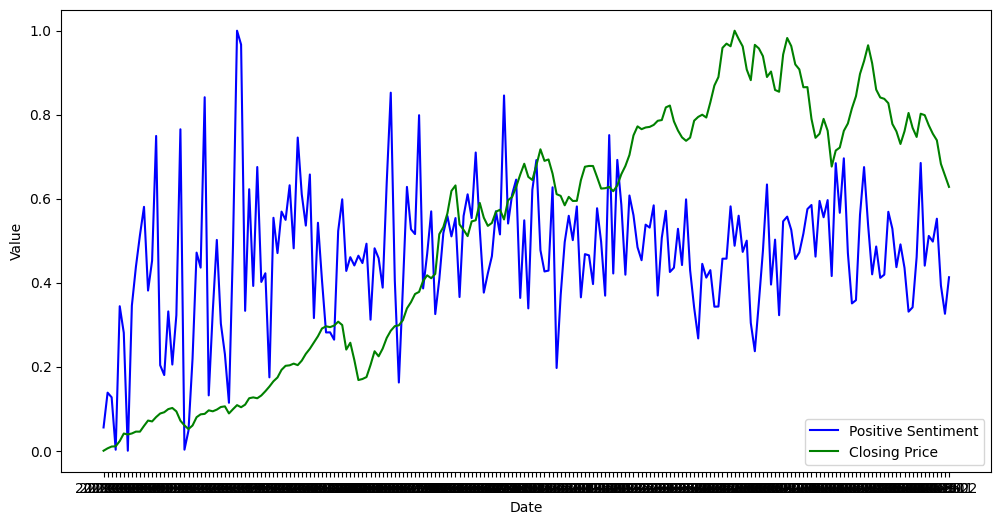

In [109]:
import matplotlib.pyplot as plt
sentiment_values = weekly_df['positive'].values
close_values = weekly_df['close'].values
scaler = MinMaxScaler()
sentiment_values_scaled = scaler.fit_transform(sentiment_values.reshape(-1, 1))[:, 0]
close_values_scaled = scaler.fit_transform(close_values.reshape(-1, 1))[:, 0]
time_axis = weekly_df.index.values
plt.figure(figsize=(12, 6))
plt.plot(time_axis, sentiment_values_scaled, label='Positive Sentiment', color='blue')
plt.plot(time_axis, close_values_scaled, label='Closing Price', color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# train_data = monthly_df
# predictors = ['positive', 'negative', 'neutral']

# model = LSTM(len(predictors), 64, 2, batch_first=True)  # input size is the length of predictors
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# loss_fn = MSELoss()

# for start_idx in range(len(monthly_df) - 1):
#     train_window = monthly_df.iloc[start_idx:start_idx+1][predictors + ['close']]
#     test_window = monthly_df.iloc[start_idx+1:start_idx+2][['close']]  # only include 'close' column to avoid data leakage

#     train_features = torch.from_numpy(train_window[predictors].values).float()
#     train_close = torch.tensor(train_window['close'].values).float()

#     # Train on the window
#     output, _ = model(train_features.unsqueeze(0))
#     train_close_predicted = train_close + output.squeeze() # add sentiment prediction to train window's close to predict test window's close

#     # Compute training loss
#     loss = loss_fn(train_close_predicted, train_close)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     print(f"Epoch: {start_idx+1}/{len(monthly_df)-1}, Train Loss: {loss.item():.4f}")
    
#     # Print predicted vs actual closing prices
#     print("Predicted Close:", train_close_predicted[0].item())
#     print("Actual Close:", train_close)

#     if start_idx < len(monthly_df) - 2:
#         # Evaluate on the test set (separate from the training data)
#         test_close = torch.tensor(test_window['close'].values).float()

#         with torch.no_grad():
#             test_output, _ = model(test_close.unsqueeze(0))
#             test_close_predicted = test_output.squeeze() + test_window['close'].values
            
#             test_loss = loss_fn(test_close_predicted, test_close)
#             print(f"Epoch: {start_idx+1}/{len(monthly_df)-1}, Test Loss: {test_loss.item():.4f}")